# MultiClass Image Classification using CNN

Dataset : Intel-image-classification


For training data and validation
accuracy: 0.9392 - val_loss: 0.4049 - val_accuracy: 0.8903 - lr: 1.0000e-06 - 113s/epoch - 257ms/step

For test data
74ms/step - loss: 0.4049 - accuracy: 0.8903

### Importing the libraries

In [1]:
!pip install comet_ml

In [2]:
# For Comet to start tracking a training run,
# just add these two lines at the top of
# your training script:
import comet_ml

experiment = comet_ml.Experiment(
    api_key="Your Api Key",
    project_name="cnn_intel_dataset"
)

# Metrics from this training run will now be
# available in the Comet UI

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: You are trying to log string value as a metric. This is not recommended.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tarunkeshukumar/cnn-intel-dataset/accd01dc5a464d0ba94e5f024b5369f8



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [5]:
tf.__version__

'2.12.0'

In [6]:
# train_dataset_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
# validation_dataset_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

## Part 1 - Data Preprocessing

### Preprocessing the Training set

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/kaggle/input/intel-image-classification/seg_train/seg_train/',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                shuffle=True)

Found 14034 images belonging to 6 classes.


### Preprocessing the Test set

In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/kaggle/input/intel-image-classification/seg_test/seg_test/',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                           shuffle=False)

Found 3000 images belonging to 6 classes.


# Label mapping

In [9]:
labels = {value: key for key, value in training_set.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


## Some images

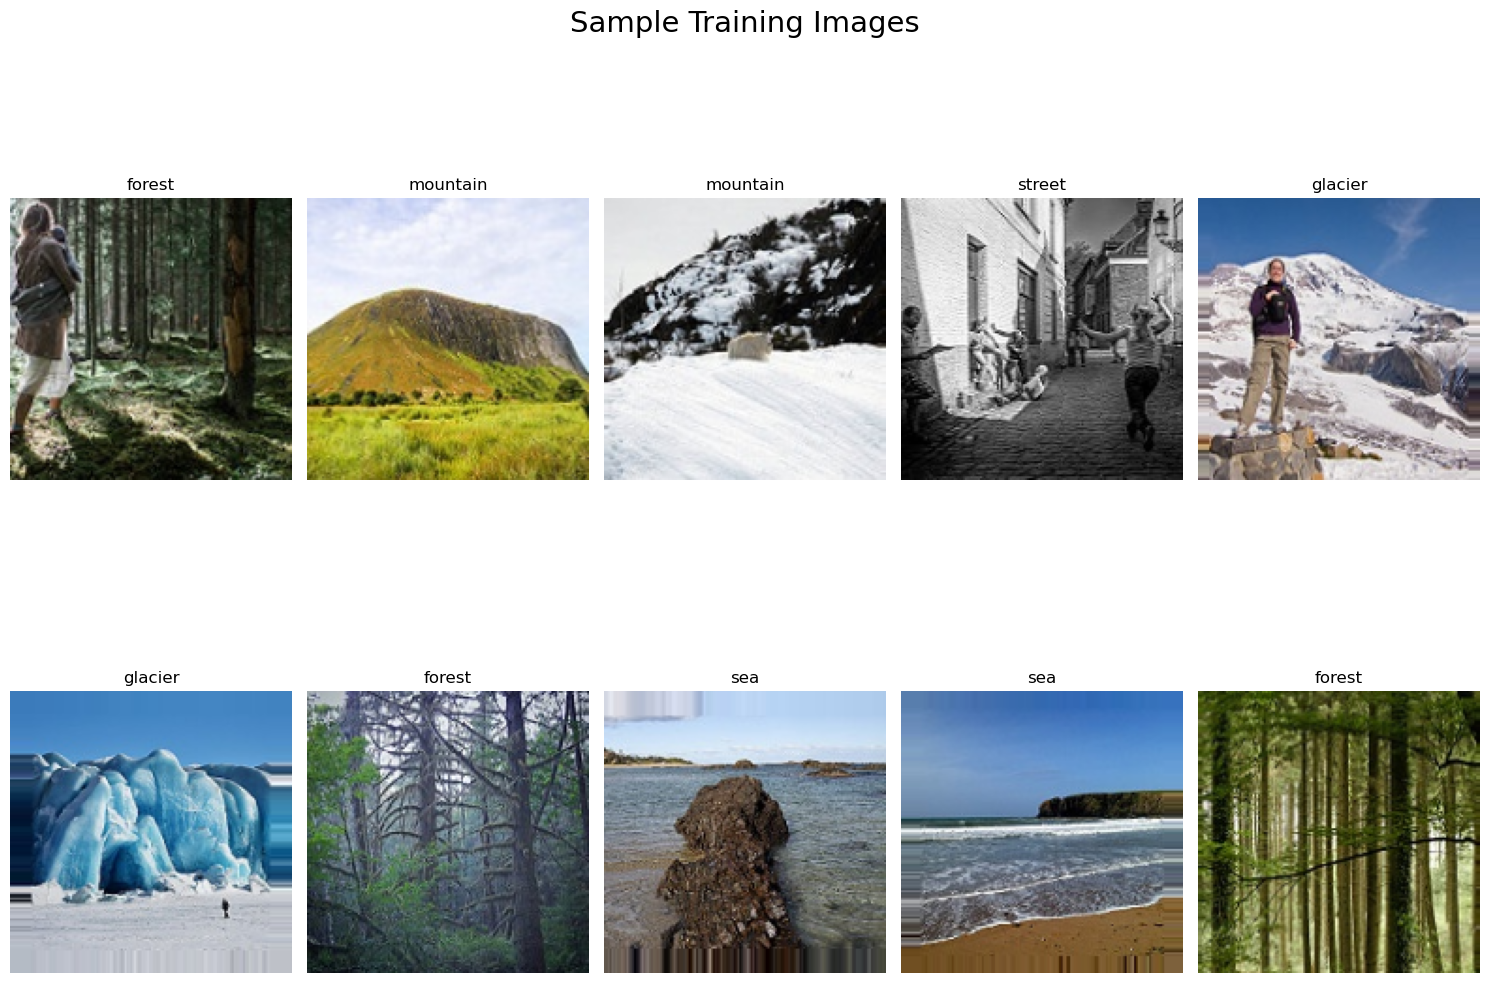

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(training_set[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(training_set[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

## Part 2 - Building the CNN

### Initialising the CNN

In [11]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [12]:
# cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

In [13]:
IMG_WIDTH, IMG_HEIGHT = 150,150

In [14]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

In [15]:
cnn_model = create_model()

In [16]:
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)       

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)


In [18]:
optimizer = Adam(learning_rate=0.001)


### Compiling the model

In [19]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])


### Training the CNN on the Training set and evaluating it on the Test set

In [20]:
history = cnn_model.fit(training_set, epochs=50, validation_data=test_set,
                       verbose=2,
                       callbacks=[reduce_lr])

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/50
439/439 - 143s - loss: 1.9712 - accuracy: 0.5258 - val_loss: 1.1685 - val_accuracy: 0.5807 - lr: 0.0010 - 143s/epoch - 326ms/step
Epoch 2/50
439/439 - 111s - loss: 1.0265 - accuracy: 0.6434 - val_loss: 0.8250 - val_accuracy: 0.6943 - lr: 0.0010 - 111s/epoch - 252ms/step
Epoch 3/50
439/439 - 108s - loss: 0.8529 - accuracy: 0.7004 - val_loss: 1.1066 - val_accuracy: 0.6000 - lr: 0.0010 - 108s/epoch - 246ms/step
Epoch 4/50
439/439 - 109s - loss: 0.7649 - accuracy: 0.7284 - val_loss: 1.1899 - val_accuracy: 0.6090 - lr: 0.0010 - 109s/epoch - 249ms/step
Epoch 5/50
439/439 - 110s - loss: 0.6922 - accuracy: 0.7501 - val_loss: 1.1370 - val_accuracy: 0.6187 - lr: 0.0010 - 110s/epoch - 251ms/step
Epoch 6/50
439/439 - 110s - loss: 0.6381 - accuracy: 0.7744 - val_loss: 0.7701 - val_accuracy: 0.7377 - lr: 0.0010 - 110s/epoch - 250ms/step
Epoch 7/50
439/439 - 110s - loss: 0.6174 - accuracy: 0.7856 - val_loss: 0.8743 - val_accuracy: 0.7163 - lr: 0.0010 - 110s/epoch - 250ms/step
Epoch 8/50
43

In [21]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

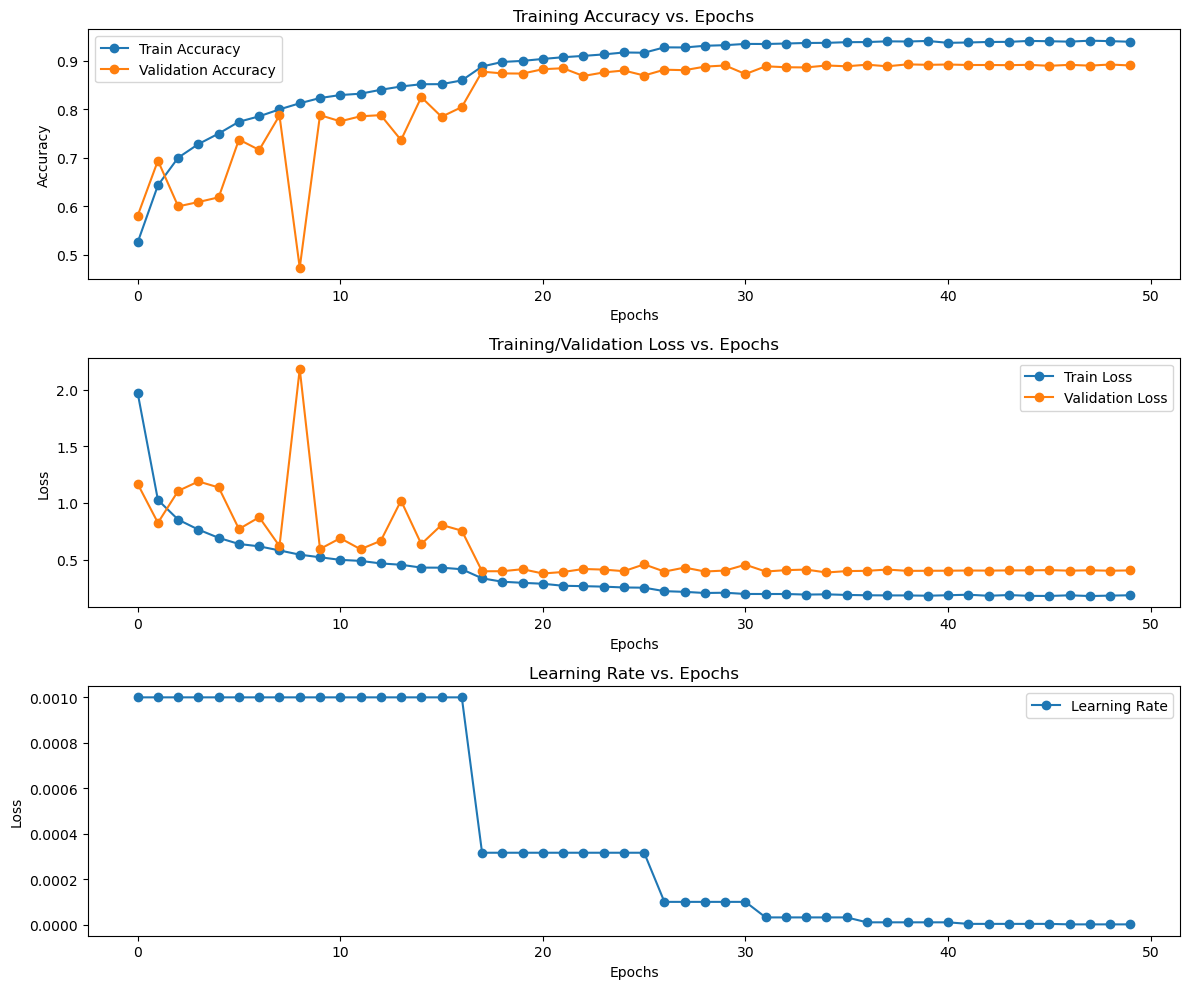

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [23]:
predictions = cnn_model.predict(test_set)

94/94 [==============================] - 8s 80ms/step


## Making prediction 

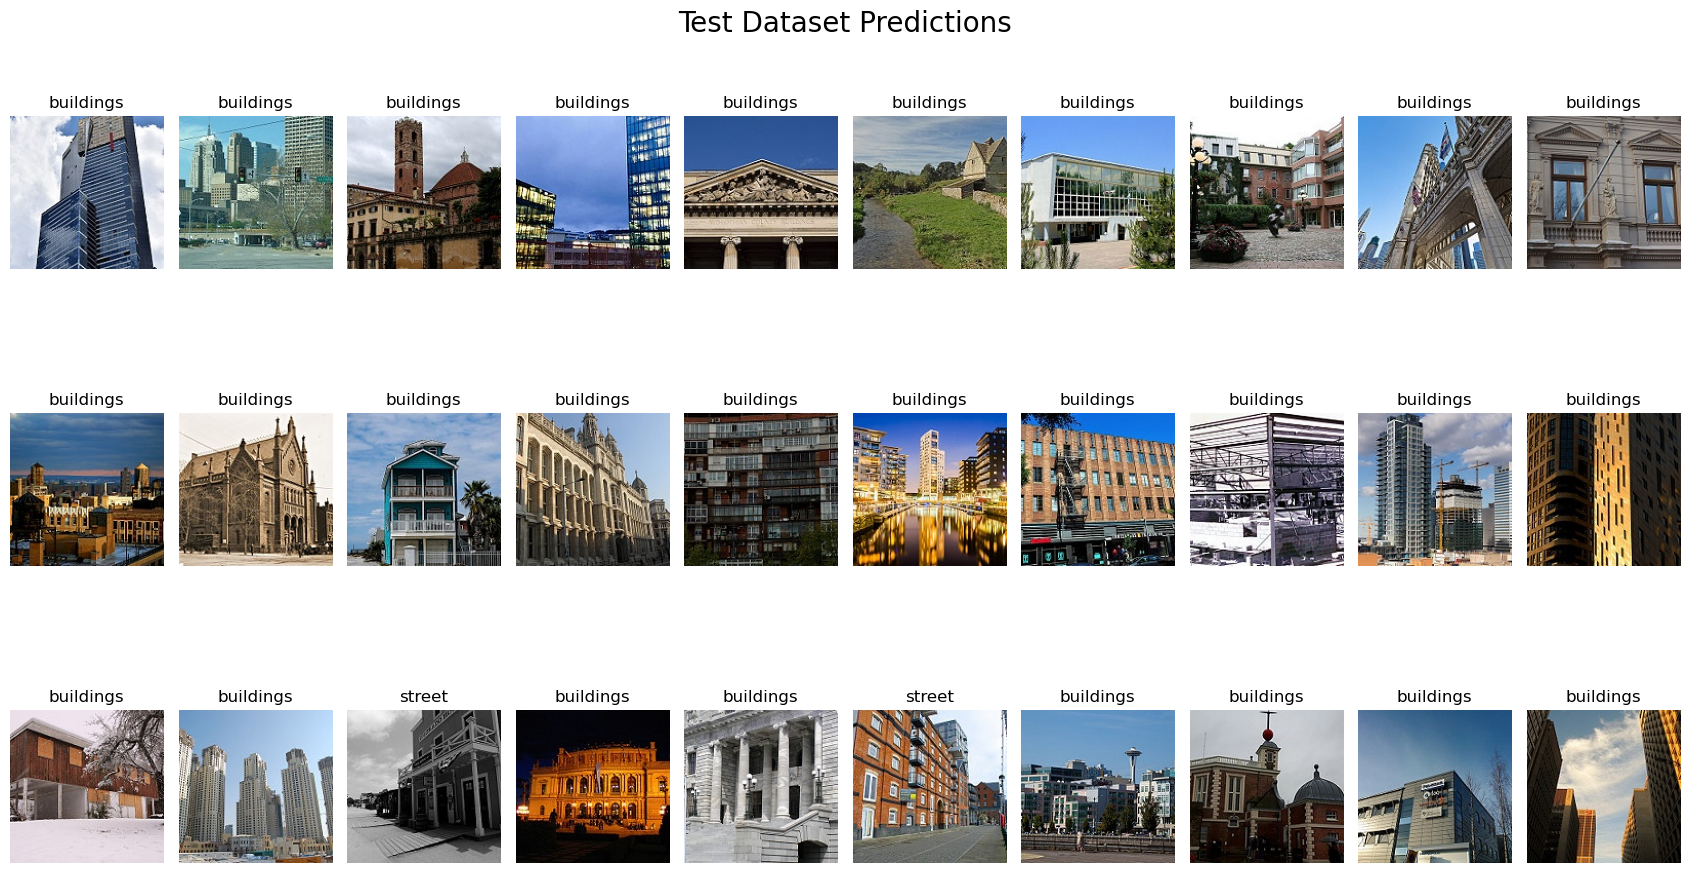

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(17, 10))
idx = 0

for i in range(3):
    for j in range(10):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_set[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

##  Model Accuracy on test-data

In [47]:
cnn_model.evaluate(test_set, verbose=True )

94/94 [==============================] - 7s 74ms/step - loss: 0.4049 - accuracy: 0.8903


[0.4049241542816162, 0.890333354473114]

In [31]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tarunkeshukumar/cnn-intel-dataset/accd01dc5a464d0ba94e5f024b5369f8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [50]                 : (0.525794506072998, 0.9414279460906982)
COMET INFO:     batch_accuracy [2200]         : (0.28125, 1.0)
COMET INFO:     batch_loss [2200]             : (0.04394995793700218, 3.6017792224884033)
COMET INFO:     epoch_duration [50]           : (107.99342950299979, 143.11756084199988)
COMET INFO:     loss [50]                     : (0.17883360385894775, 1.9711570739746094)
COMET INFO:     lr [50]                       : (1.0000001111620804e-06, 0.0010000000474974513)
COMET INFO: